In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn
import numpy as np

import torch
from torch import nn


import re
import string
import nltk
stopwords = nltk.corpus.stopwords.words("english")
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [95]:
df=pd.read_csv("C:\Datasets\spam_ham_dataset.csv\spam_ham_dataset.csv")
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [97]:
values=df['label'].value_counts()
values

label
ham     3672
spam    1499
Name: count, dtype: int64

In [98]:
ps=PorterStemmer()
lm=WordNetLemmatizer()
def preprocess(text):
    #Punctuations
    text="".join([i for i in text if i not in string.punctuation])
    #Lowercase
    text=text.lower()
    #Tokenize
    text=re.split("W+",text)
    #Stopwords
    text=[i for i in text if i not in stopwords]
    #Stemmitiztaion
    text=[ps.stem(i) for i in text]
    #Lemmatization
    text=[lm.lemmatize(i) for i in text]
    #Joining the Tokens
    text=" ".join(text)
    return text

In [99]:
df['text']=df['text'].apply(lambda x:preprocess(x) )
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,subject enron methanol meter 988291\r\nthis...,0
1,2349,ham,subject hpl nom for january 9 2001\r\n see at...,0
2,3624,ham,subject neon retreat\r\nho ho ho we re aroun...,0
3,4685,spam,subject photoshop windows office cheap mai...,1
4,2030,ham,subject re indian springs\r\nthis deal is to ...,0


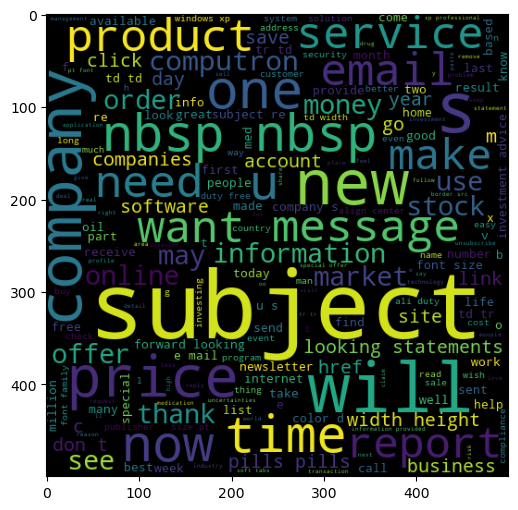

In [100]:
wc = WordCloud(width=500,height=500)
spam_wc = wc.generate(df[df['label_num'] == 1]['text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

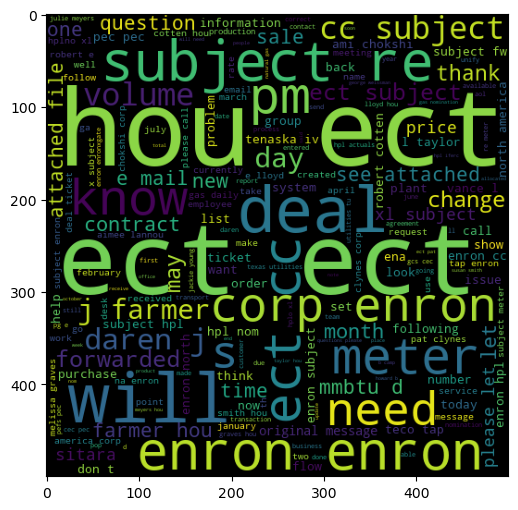

In [101]:
wc = WordCloud(width=500,height=500)
spam_wc = wc.generate(df[df['label_num'] == 0]['text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

In [102]:
X=df['text']
y=df['label_num']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state = 2)

In [103]:
vectorizer = CountVectorizer()
X_train_V = vectorizer.fit_transform(X_train)
X_test_V = vectorizer.transform(X_test)

In [104]:
X_train_V.shape

(4136, 45470)

In [105]:
X_train_tensor = torch.tensor(X_train_V.toarray(),
                             dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values,
                             dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_V.toarray(),
                             dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values,
                             dtype=torch.float32)

In [106]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset,batch_size=64)
test_loader = DataLoader(test_dataset,batch_size=64)

In [107]:
class Classify(nn.Module):
    def __init__(self):
        super(Classify,self).__init__()
        self.Layer=nn.Sequential(
            nn.Linear(45470,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,16),
            nn.ReLU(),
            nn.Linear(16,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.Layer(x)

In [108]:
model=Classify()

In [109]:
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

In [110]:
epochs=6
losses=0.0
for epoch in range(epochs):
    losses=0.0
    model.train()
    for text,label in train_loader:
        optimizer.zero_grad()
        y_pred=model(text)
        loss=criterion(y_pred,label.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print(f'Epoch {epoch+1}/{epochs} for Loss {losses}')

Epoch 1/6 for Loss 18.64456220716238
Epoch 2/6 for Loss 4.053463367046788
Epoch 3/6 for Loss 0.5898361354484223
Epoch 4/6 for Loss 0.1718405850660929
Epoch 5/6 for Loss 0.07615732590238622
Epoch 6/6 for Loss 0.04093098486987401


In [111]:
model.eval()

correct = 0
total = 0
true_positives = 0
predicted_positives = 0
actual_positives = 0
with torch.inference_mode():
    for text, labels in test_loader:
        y_pred = model(text)
        predicted = (y_pred > 0.5).float()
        
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(dim=1)).sum().item()

        

        true_positives += ((predicted == 1) & (labels.unsqueeze(dim=1) == 1)).sum().item()
        predicted_positives += (predicted == 1).sum().item()
        actual_positives += (labels == 1).sum().item()

accuracy = correct / total
precision = true_positives / predicted_positives if predicted_positives > 0 else 0
recall = true_positives / actual_positives if actual_positives > 0 else 0
print('Test Accuarcy: {:.2f}%'.format(100 * accuracy))

Test Accuarcy: 98.55%


In [112]:
class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X.toarray())
            output = self.model(X_tensor)
            predictions = (output > 0.5).int().numpy().flatten()
        return predictions

wrapped_model = ModelWrapper(model)

In [113]:
import pickle

with open('model.pkl','wb') as file:
    pickle.dump(model,file)

In [114]:
with open('vectorizer.pkl','wb') as file:
    pickle.dump(vectorizer,file)